# Fine-Tuning GPT-2 on Encrypted Data with LoRA and Concrete-ML

In this notebook, we peform fine-tuning of a GPT-2 model using LoRA and Concrete-ML. This allows us to fine-tune a model in a privacy-preserving manner.

LoRA weight can be used 

In [1]:
# Import necessary libraries
import math
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from peft import LoraConfig, TaskType, get_peft_model
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    TextDataset,
    Trainer,
    TrainingArguments,
)
from utils_lora import generate_text, print_weights_and_size

from concrete.ml.torch.hybrid_model import HybridFHEModel
from concrete.ml.torch.lora import LoraTraining, get_remote_names

# Set random seed for reproducibility
SEED = 0
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [2]:
# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [3]:
# Example usage of the pre-trained model
torch.manual_seed(SEED)
prompt = "What is FHE?"
generated_text = generate_text(prompt, model, tokenizer)
print(generated_text)

What is FHE?

FHE is a new type of energy storage that is designed to be used in a variety of applications. It is used to store energy in


In [4]:
# Configure LoRA
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    fan_in_fan_out=True,
)

# Apply LoRA to the model
peft_model = get_peft_model(model, peft_config)

In [5]:
# Set up LoRA training
lora_training = LoraTraining(peft_model)

In [6]:
# Prepare dataset for fine-tuning
BLOCK_SIZE = 128

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="data_finetune/what_is_fhe.txt",
    block_size=BLOCK_SIZE,
    cache_dir="cache_dataset",
)

In [7]:
# Set up data collator for language modeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Define training arguments
EPOCHS = 50
PER_DEVICE_TRAIN_BATCH_SIZE = 4

training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    save_total_limit=1,
    use_cpu=True,
    learning_rate=5e-3,
    logging_strategy="epoch",
    optim="adamw_torch",
    seed=SEED,
    data_seed=SEED,
    weight_decay=0.0,
    warmup_steps=0,
    max_grad_norm=1.0,
)

In [8]:
# Initialize Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# Prepare for training
train_dataloader = trainer.get_train_dataloader()

len_dataloader = len(train_dataloader)
num_update_steps_per_epoch = len_dataloader // training_args.gradient_accumulation_steps
num_update_steps_per_epoch = max(num_update_steps_per_epoch, 1)
max_steps = math.ceil(training_args.num_train_epochs * num_update_steps_per_epoch)

trainer.create_optimizer_and_scheduler(num_training_steps=max_steps)

lora_training.update_training_parameters(
    trainer.optimizer, trainer.lr_scheduler, None, training_args
)

In [9]:
# Get the names of the remote modules (layers to be converted to FHE)
remote_names = get_remote_names(lora_training, include_embedding_layers=False)

In [10]:
# Create the HybridFHEModel with the specified remote modules
hybrid_model = HybridFHEModel(lora_training, module_names=remote_names)

In [11]:
# Prepare input data for calibration
input_tensor = torch.randint(0, 2, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE)) * (
    tokenizer.vocab_size - 1
)
label_tensor = torch.randint(0, 2, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE)) * (
    tokenizer.vocab_size - 1
)

inputset = (input_tensor, label_tensor)

In [12]:
# Calibrate and compile the model
hybrid_model.model.toggle_calibrate(enable=True)
hybrid_model.compile_model(inputset, n_bits=16)
hybrid_model.model.toggle_calibrate(enable=False)

In [13]:
def train_custom_model(
    hybrid_model, train_dataloader, training_args, fhe="disable"
):  # pylint: disable=too-many-locals
    device = "cpu"
    hybrid_model.model.to(device)

    # Training loop
    hybrid_model.model.inference_model.train()
    hybrid_model.model.run_optimizer = True
    total_epochs = int(training_args.num_train_epochs)
    epoch_pbar = tqdm(total=total_epochs, desc="Training Progress", position=0)

    total_batched_samples = 0
    epoch_losses = []  # List to store the loss for each epoch

    for epoch in range(total_epochs):
        total_loss = 0
        grad_norms = []

        for _, batch in enumerate(train_dataloader):
            total_batched_samples += 1

            batch = {k: v.to(device) for k, v in batch.items()}

            loss, grad_norm = hybrid_model((batch["input_ids"], batch["labels"]), fhe=fhe)

            total_loss += loss.item()

            if grad_norm is not None:
                grad_norms.append(grad_norm)

        # Get current learning rate
        current_lr = hybrid_model.model.lr_scheduler.get_last_lr()[0]

        # Get last grad norm
        current_grad_norm = grad_norms[-1] if grad_norms else None

        # Store the total loss for this epoch
        epoch_losses.append(total_loss)

        # Log epoch results
        print(
            f"Epoch {epoch + 1}/{training_args.num_train_epochs}, "
            f"Loss: {total_loss:.4f}, grad norm: {current_grad_norm}, lr: {current_lr}"
        )

        epoch_pbar.update(1)

    # Save model checkpoint
    if training_args.output_dir is not None:
        save_path = f"{training_args.output_dir}/checkpoint-{epoch + 1}"
        hybrid_model.model.inference_model.save_pretrained(save_path)

    epoch_pbar.close()

    # Plot the loss evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, total_epochs + 1), epoch_losses, marker="o")
    plt.title("Loss Evolution During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.grid(True)
    plt.show()

Training Progress:   2%|▏         | 1/50 [03:51<3:09:00, 231.45s/it]

Epoch 1/50, Loss: 1.5293, grad norm: 0.26893383264541626, lr: 0.0049


Training Progress:   4%|▍         | 2/50 [05:40<2:07:19, 159.16s/it]

Epoch 2/50, Loss: 1.4160, grad norm: 0.31498977541923523, lr: 0.0048


Training Progress:   6%|▌         | 3/50 [07:30<1:47:15, 136.92s/it]

Epoch 3/50, Loss: 1.3174, grad norm: 0.46629607677459717, lr: 0.0047


Training Progress:   8%|▊         | 4/50 [09:19<1:36:28, 125.85s/it]

Epoch 4/50, Loss: 1.2271, grad norm: 0.45611774921417236, lr: 0.0046


Training Progress:  10%|█         | 5/50 [11:10<1:30:24, 120.54s/it]

Epoch 5/50, Loss: 1.1037, grad norm: 0.4365246593952179, lr: 0.0045000000000000005


Training Progress:  12%|█▏        | 6/50 [13:02<1:26:10, 117.52s/it]

Epoch 6/50, Loss: 1.0164, grad norm: 0.5805991291999817, lr: 0.0044


Training Progress:  14%|█▍        | 7/50 [14:54<1:22:54, 115.69s/it]

Epoch 7/50, Loss: 0.9436, grad norm: 0.5344417691230774, lr: 0.0043


Training Progress:  16%|█▌        | 8/50 [16:46<1:20:10, 114.52s/it]

Epoch 8/50, Loss: 0.8834, grad norm: 0.49370115995407104, lr: 0.0042


Training Progress:  18%|█▊        | 9/50 [18:36<1:17:27, 113.37s/it]

Epoch 9/50, Loss: 0.8083, grad norm: 0.47344064712524414, lr: 0.0040999999999999995


Training Progress:  20%|██        | 10/50 [20:28<1:15:15, 112.89s/it]

Epoch 10/50, Loss: 0.7878, grad norm: 0.6165868043899536, lr: 0.004


Training Progress:  22%|██▏       | 11/50 [22:20<1:13:11, 112.60s/it]

Epoch 11/50, Loss: 0.6856, grad norm: 0.5915069580078125, lr: 0.0039000000000000003


Training Progress:  24%|██▍       | 12/50 [24:12<1:11:14, 112.50s/it]

Epoch 12/50, Loss: 0.6489, grad norm: 0.564167320728302, lr: 0.0038


Training Progress:  26%|██▌       | 13/50 [26:05<1:09:25, 112.57s/it]

Epoch 13/50, Loss: 0.6073, grad norm: 0.5995159149169922, lr: 0.0037


Training Progress:  28%|██▊       | 14/50 [27:56<1:07:18, 112.18s/it]

Epoch 14/50, Loss: 0.5605, grad norm: 0.6373062133789062, lr: 0.0036


Training Progress:  30%|███       | 15/50 [29:49<1:05:29, 112.27s/it]

Epoch 15/50, Loss: 0.5484, grad norm: 0.6709274053573608, lr: 0.0034999999999999996


Training Progress:  32%|███▏      | 16/50 [31:42<1:03:44, 112.48s/it]

Epoch 16/50, Loss: 0.5117, grad norm: 0.6581171154975891, lr: 0.0034000000000000002


Training Progress:  34%|███▍      | 17/50 [33:32<1:01:28, 111.77s/it]

Epoch 17/50, Loss: 0.4514, grad norm: 0.6061685085296631, lr: 0.0033000000000000004


Training Progress:  36%|███▌      | 18/50 [35:27<1:00:11, 112.87s/it]

Epoch 18/50, Loss: 0.4213, grad norm: 0.6834462881088257, lr: 0.0032


Training Progress:  38%|███▊      | 19/50 [37:19<58:08, 112.54s/it]  

Epoch 19/50, Loss: 0.3943, grad norm: 0.5822382569313049, lr: 0.0031


Training Progress:  40%|████      | 20/50 [39:11<56:11, 112.40s/it]

Epoch 20/50, Loss: 0.3748, grad norm: 0.6392336487770081, lr: 0.003


Training Progress:  42%|████▏     | 21/50 [41:05<54:35, 112.94s/it]

Epoch 21/50, Loss: 0.3499, grad norm: 0.6496515274047852, lr: 0.0029


Training Progress:  44%|████▍     | 22/50 [42:57<52:33, 112.63s/it]

Epoch 22/50, Loss: 0.3119, grad norm: 0.5828952789306641, lr: 0.0028000000000000004


Training Progress:  46%|████▌     | 23/50 [44:50<50:37, 112.51s/it]

Epoch 23/50, Loss: 0.2947, grad norm: 0.6116949319839478, lr: 0.0027


Training Progress:  48%|████▊     | 24/50 [46:42<48:45, 112.52s/it]

Epoch 24/50, Loss: 0.2675, grad norm: 0.5178778767585754, lr: 0.0026000000000000003


Training Progress:  50%|█████     | 25/50 [48:34<46:49, 112.37s/it]

Epoch 25/50, Loss: 0.2693, grad norm: 0.5194953680038452, lr: 0.0025


Training Progress:  52%|█████▏    | 26/50 [50:29<45:16, 113.20s/it]

Epoch 26/50, Loss: 0.2615, grad norm: 0.4978559613227844, lr: 0.0024


Training Progress:  54%|█████▍    | 27/50 [52:22<43:18, 112.99s/it]

Epoch 27/50, Loss: 0.2409, grad norm: 0.5578598380088806, lr: 0.0023


Training Progress:  56%|█████▌    | 28/50 [54:16<41:34, 113.39s/it]

Epoch 28/50, Loss: 0.2106, grad norm: 0.5013924241065979, lr: 0.0022


Training Progress:  58%|█████▊    | 29/50 [56:11<39:48, 113.72s/it]

Epoch 29/50, Loss: 0.1995, grad norm: 0.5068638920783997, lr: 0.0021


Training Progress:  60%|██████    | 30/50 [58:06<38:03, 114.17s/it]

Epoch 30/50, Loss: 0.1886, grad norm: 0.4624735713005066, lr: 0.002


Training Progress:  62%|██████▏   | 31/50 [1:00:00<36:10, 114.23s/it]

Epoch 31/50, Loss: 0.1809, grad norm: 0.47801023721694946, lr: 0.0019


Training Progress:  64%|██████▍   | 32/50 [1:01:54<34:14, 114.14s/it]

Epoch 32/50, Loss: 0.1922, grad norm: 0.48612886667251587, lr: 0.0018


Training Progress:  66%|██████▌   | 33/50 [1:03:47<32:14, 113.77s/it]

Epoch 33/50, Loss: 0.1709, grad norm: 0.5003017783164978, lr: 0.0017000000000000001


Training Progress:  68%|██████▊   | 34/50 [1:05:42<30:28, 114.25s/it]

Epoch 34/50, Loss: 0.1439, grad norm: 0.4307801425457001, lr: 0.0016


Training Progress:  70%|███████   | 35/50 [1:07:37<28:36, 114.40s/it]

Epoch 35/50, Loss: 0.1463, grad norm: 0.5467321872711182, lr: 0.0015


Training Progress:  72%|███████▏  | 36/50 [1:09:32<26:42, 114.45s/it]

Epoch 36/50, Loss: 0.1508, grad norm: 0.45066747069358826, lr: 0.0014000000000000002


Training Progress:  74%|███████▍  | 37/50 [1:11:27<24:50, 114.64s/it]

Epoch 37/50, Loss: 0.1192, grad norm: 0.30783766508102417, lr: 0.0013000000000000002


Training Progress:  76%|███████▌  | 38/50 [1:13:21<22:54, 114.58s/it]

Epoch 38/50, Loss: 0.1304, grad norm: 0.374083936214447, lr: 0.0012


Training Progress:  78%|███████▊  | 39/50 [1:15:16<21:01, 114.68s/it]

Epoch 39/50, Loss: 0.1229, grad norm: 0.3749005198478699, lr: 0.0011


Training Progress:  80%|████████  | 40/50 [1:17:12<19:08, 114.88s/it]

Epoch 40/50, Loss: 0.1368, grad norm: 0.4631400406360626, lr: 0.001


Training Progress:  82%|████████▏ | 41/50 [1:19:06<17:13, 114.88s/it]

Epoch 41/50, Loss: 0.1113, grad norm: 0.3872043788433075, lr: 0.0009


Training Progress:  84%|████████▍ | 42/50 [1:21:00<15:16, 114.57s/it]

Epoch 42/50, Loss: 0.1018, grad norm: 0.35070037841796875, lr: 0.0008


Training Progress:  86%|████████▌ | 43/50 [1:22:53<13:18, 114.09s/it]

Epoch 43/50, Loss: 0.1029, grad norm: 0.32102227210998535, lr: 0.0007000000000000001


Training Progress:  88%|████████▊ | 44/50 [1:24:47<11:24, 114.12s/it]

Epoch 44/50, Loss: 0.1060, grad norm: 0.347727507352829, lr: 0.0006


Training Progress:  90%|█████████ | 45/50 [1:26:42<09:30, 114.13s/it]

Epoch 45/50, Loss: 0.1112, grad norm: 0.4068537652492523, lr: 0.0005


Training Progress:  92%|█████████▏| 46/50 [1:28:33<07:33, 113.31s/it]

Epoch 46/50, Loss: 0.0966, grad norm: 0.3004630506038666, lr: 0.0004


Training Progress:  94%|█████████▍| 47/50 [1:30:28<05:41, 113.70s/it]

Epoch 47/50, Loss: 0.0892, grad norm: 0.2901763617992401, lr: 0.0003


Training Progress:  96%|█████████▌| 48/50 [1:32:22<03:47, 113.88s/it]

Epoch 48/50, Loss: 0.0976, grad norm: 0.3275894224643707, lr: 0.0002


Training Progress:  98%|█████████▊| 49/50 [1:34:16<01:54, 114.07s/it]

Epoch 49/50, Loss: 0.0897, grad norm: 0.3097344934940338, lr: 0.0001


Training Progress: 100%|██████████| 50/50 [1:36:13<00:00, 114.71s/it]

Epoch 50/50, Loss: 0.0938, grad norm: 0.35130730271339417, lr: 0.0


Training Progress: 100%|██████████| 50/50 [1:36:13<00:00, 115.47s/it]


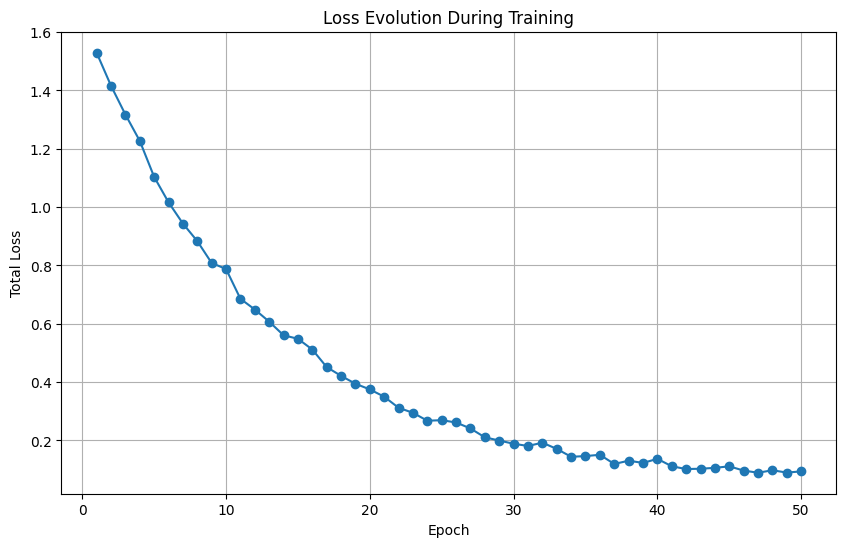

In [14]:
# Avoid parallelism error from HuggingFace during training
tokenizer.parallelism = False

# Train the model using FHE simulation
train_custom_model(hybrid_model, train_dataloader, training_args, fhe="simulate")

In [15]:
# Get the fine-tuned model
fine_tuned_model = hybrid_model.model.inference_model

# Set FHE mode to disable for text generation
hybrid_model.set_fhe_mode("disable")

In [16]:
# Inference using the fine-tuned model with LoRA weights
# Seed for reproducibility
torch.manual_seed(SEED)

prompt = "What is FHE?"
generated_text = generate_text(prompt, fine_tuned_model, tokenizer)
print(generated_text)

What is FHE??

Fully Homomorphic Encryption (FHE) is a groundbreaking cryptographic technique that allows computations to be performed directly on encrypted data without


In [17]:
# Original inference without LoRA weights
# Seed for reproducibility
torch.manual_seed(SEED)

peft_model.disable_adapter_layers()

prompt = "What is FHE?"
generated_text = generate_text(prompt, fine_tuned_model, tokenizer)
print(generated_text)

What is FHE?

FHE is a term that refers to the ability to generate a number of numbers from a given number.
. The number is the number


In [18]:
peft_model.enable_adapter_layers()

# Print weights and model size
total_weights_size = print_weights_and_size(hybrid_model.model)

Total number of weights: 124734720
Total number of LoRA weights: 294912


In [19]:
# Save the model
path = Path("deployment/gpt2_lora_finetuned")
path.mkdir(parents=True, exist_ok=True)

if path.is_dir() and any(path.iterdir()):
    shutil.rmtree(path)

hybrid_model.save_and_clear_private_info(path)

In [20]:
# Print weights and size after saving
total_weights_size_private = print_weights_and_size(hybrid_model.model)

Total number of weights: 39717120
Total number of LoRA weights: 294912


In [21]:
# Calculate and print the percentage of weights removed
percentage_removed = (total_weights_size - total_weights_size_private) / total_weights_size * 100
print(f"Total weights removed: {percentage_removed:.2f} %")

Total weights removed: 68.16 %


In [22]:
# Note: Around 95% of the remaining weights are from the embedding layers (wpe and wte)
# as well as the final lm_head layer.